In [90]:
import numpy as np
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [91]:
word2vec_model_path = "GoogleNews-vectors-negative300.bin"  # Path to the Word2Vec model file
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)

In [92]:
# Example dataset of business categories and corresponding investors
business_investors = {
    'Milk': ['Mother Dairy', 'Amul', 'Danone', 'Nestle'],
    'Cement': ['LafargeHolcim', 'Cemex', 'HeidelbergCement', 'CRH'],
    'Grocery': ['Walmart', 'Tesco', 'Carrefour', 'Amazon'],
    'Clothes': ['Zara', 'H&M', 'Gap', 'Uniqlo'],
    'Technology': ['Google Ventures', 'Sequoia Capital', 'Andreessen Horowitz'],
    'Smartphone' : ['Samsung','iphone'],
    'DryCleaning' : ['Washers'],
    'AutoMobile' : ['Ferari, BMW']
}
# LOAD EXCEL WITH PROPER FORMAT DATA

# Function to recommend investors based on a given prompt
def recommend_investors_for_prompt(prompt, business_investors, word2vec_model):
    prompt_tokens = prompt.lower().split()

    # Calculate average vector representation of the prompt
    prompt_vector = np.mean([word2vec_model[token] for token in prompt_tokens if token in word2vec_model], axis=0)

    # Calculate similarity between the prompt and each business category
    similarities = {}
    for category, investors in business_investors.items():
        category_vector = np.mean([word2vec_model[token] for token in category.lower().split() if token in word2vec_model], axis=0)
        if category_vector is not None:
            similarities[category] = cosine_similarity([prompt_vector], [category_vector])[0][0]

    # Get the most similar business category
    most_similar_category = max(similarities, key=similarities.get)
    # print(similarities)
    # # Retrieve investors for the most similar category
    recommended_investors = business_investors[most_similar_category]


    return [most_similar_category,recommended_investors]


In [93]:
# Example text prompt
text_prompt = "I want a films buisness"

# Get recommended investors for the prompt
recommended_investors = recommend_investors_for_prompt(text_prompt, business_investors, word2vec_model)

# Print recommended investors
print("Recommended Investors for the given prompt are:", recommended_investors)

Recommended Investors for the given prompt are: ['Clothes', ['Zara', 'H&M', 'Gap', 'Uniqlo']]


In [94]:
# import pandas as pd

# # Create the dataset
# data = {
#     "User Name": ["RohanGupta", "PriyaSingh", "SanjayPatel", "NishaSharma", "RajMalhotra",
#                   "AnjaliVerma", "KartikShah", "AartiKumar", "RahulYadav", "NehaSingh",
#                   "KaranGoyal", "AnanyaRao", "RohiniPatil", "VishalSharma", "JayaVerma",
#                   "AdityaMishra", "KomalGupta", "RahulSaxena", "PriyankaReddy", "SureshKumar"],
#     "Category": ["Mobile", "Dairy", "Bakery", "Repairing", "Restaurant",
#                  "Grocery", "Fashion", "Pharmacy", "Fitness", "Salon",
#                  "Electronics", "Automotive", "Construction", "Jewelry", "Furniture",
#                  "RealEstate", "Stationery", "Photography", "Travel", "Bakery"],
#     "Location": ["Mumbai", "Delhi", "Ahmedabad", "Bangalore", "Chandigarh",
#                  "Kolkata", "Mumbai", "Chennai", "Pune", "Delhi",
#                  "Hyderabad", "Bangalore", "Mumbai", "Jaipur", "Lucknow",
#                  "Pune", "Ahmedabad", "Delhi", "Chennai", "Bangalore"],
#     "Business Size": ["Small", "Medium", "Small", "Large", "Medium",
#                       "Small", "Large", "Medium", "Small", "Large",
#                       "Medium", "Small", "Large", "Medium", "Small",
#                       "Large", "Medium", "Small", "Large", "Small"],
#     "Investors": ["TechFund, Mobile Ventures", "DairyInvest, FreshFund", "BakeCapital, Flour Fund",
#                   "FixIt Ventures, RepairFund", "FoodieFund, Restaurant Capital",
#                   "FreshGrocery Fund, MarketInvest", "StyleCapital, Fashion Angels",
#                   "MedInvest, Pharma Partners", "FitFund, Gym Angels", "BeautyInvest, Salon Capital",
#                   "TechFund, Gadget Angels", "AutoInvest, Drive Capital", "BuildIt Ventures, Construction Fund",
#                   "JewelFund, Gem Angels", "WoodWorks Capital, Furniture Fund", "RealtyInvest, Estate Capital",
#                   "PaperWorks Fund, Office Supplies Capital", "ClickFund, Photo Ventures",
#                   "TravelVentures, Trip Fund", "BakeCapital, Flour Fund"]
# }

# # Create DataFrame
# df = pd.DataFrame(data)

# # Save DataFrame to CSV
# df.to_csv('business_data.csv', index=False)
df = pd.read_csv("buisness_data.csv")
print(df.shape)

(172, 5)


In [95]:
def recommend_categ_for_prompt(prompt, df, word2vec_model):
    prompt_tokens = prompt.lower().split()

    # Calculate average vector representation of the prompt
    prompt_vector = np.mean([word2vec_model[token] for token in prompt_tokens if token in word2vec_model], axis=0)

    # Calculate similarity between the prompt and each business category
    similarities = {}
    for category in df['Category']:
        category_tokens = category.lower().split()
        category_vector = np.mean([word2vec_model[token] for token in category_tokens if token in word2vec_model], axis=0)
        if category_vector is not None and not np.isnan(category_vector).any():
            similarities[category] = cosine_similarity([prompt_vector], [category_vector])[0][0]

    # Get the most similar business category
    if similarities:  # Check if similarities dictionary is not empty
        most_similar_category = max(similarities, key=similarities.get)
        recommended_investors = df[df['Category'] == most_similar_category]['Investors'].values[0]
        return [most_similar_category, recommended_investors]
    else:
        return ["No similar category found", "No recommended investors"]

In [96]:
from sklearn.preprocessing import LabelEncoder

categories = df['Category'].unique()
category_encoded = pd.get_dummies(df['Category'], prefix='Category')
business_size_encoded = pd.get_dummies(df['Business Size'], prefix='BusinessSize')
location_encoded = pd.get_dummies(df['Location'], prefix='Location')

# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([df, category_encoded, business_size_encoded, location_encoded], axis=1)

# Drop the original columns
df_encoded.drop(columns=['Category', 'Business Size', 'Location'], inplace=True)


label_encoder = LabelEncoder()
label_encoder.fit(df_encoded['Investors'])
y_train_encoded = label_encoder.transform(df_encoded['Investors'])

X = df_encoded.drop(['User Name', 'Investors'], axis=1)

# Example usage:
prompt = "I want to start a car business"
result = recommend_categ_for_prompt(prompt,df,word2vec_model)
print("Most similar category:", result[0])
print("Recommended investors:", result[1])
print(y_train_encoded)

Most similar category: Automotive
Recommended investors: DriveForward Investment Group, AutoFund
[34 24  1 18 16 14 28 30 31 13 20 23  3 17 19 33 26 25  4 13 22 10  5 21
  2 27  7 36 35  0  6  8 12 29 11 20 15 19  1 17 34 24 18 16 14 28 30 31
 13 20 23  3 17 19 33 26 25  4 13 22  9  5 21  2 27  7 36 35  0  6  8 12
 29 32 34 24  1 18 16 14 28 30 31 13 20 23  3 17 19 33 26 25  4 10  5 21
  2 27  7 36 35  0  6  8 12 29 10 34 24  1 18 16 14 28 30 31 13 20 23  3
 17 19 33 26 25  4 10  5 21  2 27  7 36 35  0  6  8 12 29 10 34 24  1 18
 16 14 28 30 31 13 20 23  3 17 19 33 26 25  4 10  5 21  2 27  7 36 35  0
  6  8 12 29]


D:\Programs\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\Anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\Anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\Anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Anaconda\Lib\site-pack

D:\Programs\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.0546 - loss: 5.1448 - val_accuracy: 0.0000e+00 - val_loss: 5.1059
Epoch 2/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1129 - loss: 5.0856 - val_accuracy: 0.0000e+00 - val_loss: 5.0586
Epoch 3/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1314 - loss: 5.0197 - val_accuracy: 0.0465 - val_loss: 4.9892
Epoch 4/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1350 - loss: 4.9189 - val_accuracy: 0.0465 - val_loss: 4.8759
Epoch 5/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1912 - loss: 4.7531 - val_accuracy: 0.0233 - val_loss: 4.6810
Epoch 6/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1809 - loss: 4.4764 - val_accuracy: 0.0465 - val_loss: 4.3669
Epoch 7/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1406 - loss: 4.1311 - val_accuracy: 0.0930 - val_loss: 3.9816
Epoch 8/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1459 - loss: 3.6833 - val_accuracy: 0

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


D:\Programs\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


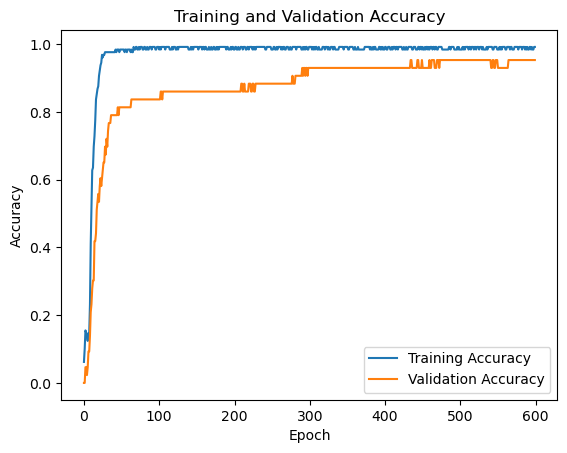

Overall Precision: 0.9504504504504506
Overall Recall: 0.9621621621621622
Overall F1-Score: 0.9522932022932022


In [97]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report

# Assuming y_train_encoded contains the ground truth labels for training data
# And X contains the features for training data

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(len(df_encoded['Investors']), activation='softmax')  # Output layer
    ])
    return model

model = create_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(X, y_train_encoded, epochs=600, batch_size=10, validation_split=0.25)
model.save("ann_recom.h5")

# Get predictions
y_pred = model.predict(X)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate classification report
class_report = classification_report(y_train_encoded, y_pred_classes, output_dict=True)
precision = class_report['macro avg']['precision']
recall = class_report['macro avg']['recall']
f1_score = class_report['macro avg']['f1-score']

# Plotting the accuracy graph
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("Overall Precision:", precision)
print("Overall Recall:", recall)
print("Overall F1-Score:", f1_score)

In [117]:
import tensorflow as tf
from recom_f_promt import recommend_categ_for_prompt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the saved model
model = tf.keras.models.load_model('ann_recom.h5')

# Make predictions

def predict_ann(prompt,loc,size):
    df = pd.read_csv("buisness_data.csv")

    label_encoder = LabelEncoder()
    label_encoder.fit(df['Investors'])
    y_train_encoded = label_encoder.transform(df['Investors'])
    categ = recommend_categ_for_prompt(prompt)[0]
    # Assuming data is your new data represented as a dictionary
    data = {
        "Category": categ,  # Replace 'New Category' with the category of your new data
        "Location": "Mumbai",  # Replace 'New Location' with the location of your new data
        "Business Size": "Small"  # Replace 'New Size' with the business size of your new data
    }

    # Create a DataFrame from the new data
    new_df = pd.DataFrame(data, index=[0])  # Creating a DataFrame with a single row

    # Concatenate the original DataFrame with the new DataFrame
    combined_df = pd.concat([df, new_df], ignore_index=True)

    # One-hot encode the combined DataFrame
    combined_df_encoded = pd.get_dummies(combined_df, columns=['Category', 'Business Size', 'Location'])

    # Extract the last row (the new data) from the combined one-hot encoded DataFrame
    new_data_encoded = combined_df_encoded.iloc[[-1]]
    new_data_encoded.drop(columns = ["User Name","Investors"], inplace=True)

    predictions = model.predict(new_data_encoded)
    predicted_labels_encoded = predictions.argmax(axis=1)  # Assuming predictions is an array of probabilities
    predicted_labels = label_encoder.inverse_transform(predicted_labels_encoded)
    print(predicted_labels)
    
predict_ann("i want to start a cafe buisness","Pune","Medium")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


D:\Programs\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\Anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\Anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\Anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Anaconda\Lib\site-pack

['CoffeeCapital, CafeVentures']


D:\Programs\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\Anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\Anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\Anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Anaconda\Lib\site-pack

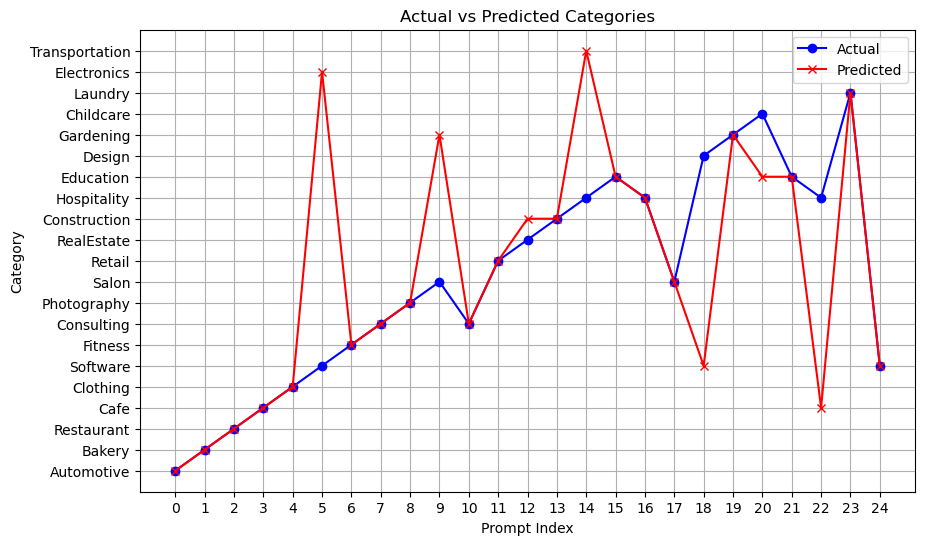

Accuracy: 72.0 %


In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Define your function
def recommend_categ_for_prompt(prompt, df, word2vec_model):
    prompt_tokens = prompt.lower().split()

    # Calculate average vector representation of the prompt
    prompt_vector = np.mean([word2vec_model[token] for token in prompt_tokens if token in word2vec_model], axis=0)

    # Calculate similarity between the prompt and each business category
    similarities = {}
    for category in df['Category']:
        category_tokens = category.lower().split()
        category_vector = np.mean([word2vec_model[token] for token in category_tokens if token in word2vec_model], axis=0)
        if category_vector is not None and not np.isnan(category_vector).any():
            similarities[category] = cosine_similarity([prompt_vector], [category_vector])[0][0]

    # Get the most similar business category
    if similarities:  # Check if similarities dictionary is not empty
        most_similar_category = max(similarities, key=similarities.get)
        return most_similar_category
    else:
        return "No similar category found"

# Prepare the prompts with categories
prompts_with_categories = [
    ["I want to start a car business", "Automotive"],
    ["thinking about starting a bakery", "Bakery"],
    ["begin a restaurant", "Restaurant"],
    ["Considering opening a coffee shop", "Cafe"],
    ["I'm interested in launching a clothing store", "Clothing"],
    ["Exploring options for starting a tech company", "Software"],
    ["Contemplating a fitness center startup", "Fitness"],
    ["Considering a freelance writing business", "Consulting"],
    ["Thinking of starting a photography studio", "Photography"],
    ["I'm passionate about opening a pet grooming salon.", "Salon"],
    ["How do I begin a consulting firm", "Consulting"],
    ["Considering launching an online store", "Retail"],
    ["I want to start a building agency", "RealEstate"],
    ["Contemplating a home renovation business.", "Construction"],
    ["Thinking of opening a travel agency", "Hospitality"],
    ["I'm interested in starting a tutoring service", "Education"],
    ["How can I start a catering business", "Hospitality"],
    ["I'm thinking about launching a beauty salon", "Salon"],
    ["Considering a graphic design business startup", "Design"],
    ["Contemplating a landscaping company", "Gardening"],
    ["I want a center for caring", "Childcare"],
    ["Thinking of starting a music school", "Education"],
    ["I'm interested in opening a bed and breakfast", "Hospitality"],
    ["begin a clothes cleaning service", "Laundry"],
    ["Considering launching a software development company.", "Software"],
    # Repeat as needed for more prompts and categories
]

# Initialize lists to store actual and predicted categories
actual_categories = []
predicted_categories = []

# Iterate over each prompt and predict the category
for prompt, actual_category in prompts_with_categories:
    # Replace `word2vec_model` with your actual Word2Vec model
    predicted_category = recommend_categ_for_prompt(prompt, df, word2vec_model)
    actual_categories.append(actual_category)
    predicted_categories.append(predicted_category)

plt.figure(figsize=(10, 6))
plt.plot(actual_categories, label='Actual', marker='o', linestyle='-', color='blue')
plt.plot(predicted_categories, label='Predicted', marker='x', linestyle='-', color='red')
plt.title('Actual vs Predicted Categories')
plt.xlabel('Prompt Index')
plt.ylabel('Category')
plt.xticks(np.arange(len(prompts_with_categories)), range(len(prompts_with_categories)))
plt.legend()
plt.grid(True)
plt.show()

correct_predictions = 0

# Iterate over each prompt and check if the prediction matches the actual category
for actual_category, predicted_category in zip(actual_categories, predicted_categories):
    if actual_category == predicted_category:
        correct_predictions += 1

# Calculate accuracy percentage
accuracy_percentage = (correct_predictions / len(actual_categories)) * 100

print("Accuracy:", accuracy_percentage, "%")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_train_encoded, test_size=0.25, random_state=42)

# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=1)  # You can adjust the number of neighbors as needed

# Train the KNN classifier
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Generate classification report
class_report = classification_report(y_test, y_pred, output_dict=True)
precision = class_report['macro avg']['precision']
recall = class_report['macro avg']['recall']
f1_score = class_report['macro avg']['f1-score']

print("Overall Precision:", precision)
print("Overall Recall:", recall)
print("Overall F1-Score:", f1_score)
